We are going to execute Canny Algorithm step by step

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from scipy import signal

def rgb2grayscale(img: np.ndarray):
    """
    img: image in RGB format
    return: image in grayscale format
    """
    return np.around((img[:, :, 0]*0.3 + img[:, :, 1]*0.59 + img[:, :, 2]*0.11))

def correlation(img: np.ndarray, filter: np.ndarray, faster: bool):
    """
    img: image in grayscale format
    filter: filter to apply to the image
    faster: boolean value. If true, use scipy implemented correlation, which is faster
    return: image after applying the filter
    """
    if faster:
        return signal.correlate2d(img, filter)

    img_x, img_y = img.shape[0], img.shape[1]
    kernel_x, kernel_y = filter.shape[0], filter.shape[1]
    if kernel_x != kernel_y:
        raise ValueError("Kernel has to be NxN")

    k = kernel_x
    new_img = np.zeros((img_x, img_y))

    pad = int((k-1)/2)

    for x in range(pad, img_x - pad):
        for y in range(pad, img_y - pad):
            subimagen = img[x - pad:x + pad + 1, y - pad:y + pad + 1]
            new_img[x, y] = np.sum(subimagen * filter)
    
    return new_img

def gaussianKernel(size: int, sigma: float):
    """
    size: size of the kernel
    sigma: standard deviation of the gaussian
    return: gaussian kernel
    """
    if size % 2 == 0:
        raise ValueError("Size must be odd")
    return np.fromfunction(
        lambda x, y: (1 / ((sigma**2)*2*math.pi))*np.exp(-(((x-((size-1)/2))**2 + (y-((size-1)/2))**2) / (2*(sigma**2)))), 
        (size, size))

def sobelFilterX():
    """
    return: sobel filter in the X direction
    """
    return np.array([[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]])

def sobelFilterY():
    """
    return: sobel filter in the Y direction
    """
    return np.array([[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]])

def nonMaximaElimination(magnitude: np.ndarray, direction: np.ndarray):
    """
    magnitude: magnitude of the gradient
    direction: direction of the gradient
    return: image after applying non-maxima elimination
    """
    result = magnitude.copy()
    for x in range(1, magnitude.shape[0]-1):
        for y in range(1, magnitude.shape[1]-1):
            ang = direction[x, y]
            mag = magnitude[x, y]

            if ang <= 30 or ang > 150:
                if not (mag >= magnitude[x, y+1] and mag >= magnitude[x, y-1]):
                    result[x, y] = 0

            elif 30 < ang <= 60:
                if not (mag >= magnitude[x+1, y+1] and mag >= magnitude[x-1, y-1]):
                    result[x, y] = 0

            elif 60 < ang <= 120:
                if not (mag >= magnitude[x+1, y] and mag >= magnitude[x-1, y]):
                    result[x, y] = 0
            else:
                if not (mag >= magnitude[x+1, y-1] and mag >= magnitude[x-1, y+1]):
                    result[x, y] = 0

    return result

def threshold(value: int, min_threshold: int, max_threshold: int):
    """
    value: value to threshold
    min_threshold: minimum threshold
    max_threshold: maximum threshold
    return: value after applying the threshold
    """
    if value <= min_threshold:
        return 0
    elif value >= max_threshold:
        return 255
    else:
        return 128
    
threshold_v = np.vectorize(threshold)

def hysteresis(img: np.ndarray):
    """
    img: image with threshole applied
    return: image after applying hysteresis
    """
    result = img.copy()
    for x in range(2, img.shape[0]-2):
        for y in range(2, img.shape[1]-2):
            if img[x, y] == 128:
                neighbors = [img[x-1, y-1], img[x-1, y], img[x-1, y+1], img[x, y+1],
                             img[x+1, y+1], img[x+1, y], img[x+1, y-1], img[x, y-1]]
                if (255 in neighbors):
                    result[x, y] = 255
                else:
                    result[x, y] = 0
    return result

ORIGINAL IMAGE

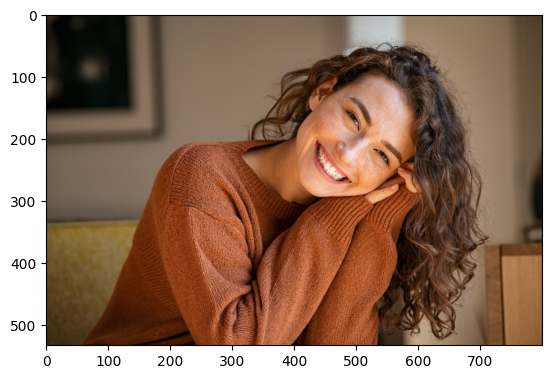

In [2]:
img = cv2.imread("../example_inputs/persona.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

BLURRY IMAGE

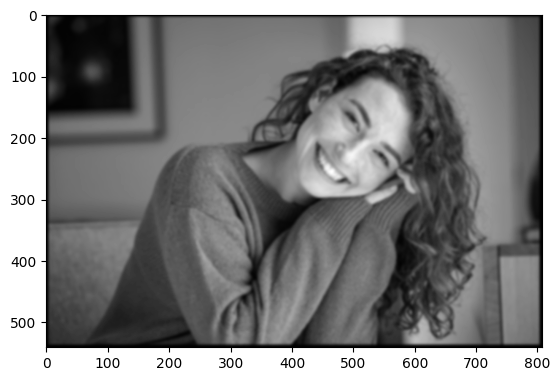

In [11]:
blurry_img = correlation(rgb2grayscale(img), gaussianKernel(9, 2), True)
plt.imshow(blurry_img, cmap='gray')

GRADIENT (MAGNITUDE AND DIRECTION)

In [12]:
sobelX = correlation(blurry_img, sobelFilterX(), True)
sobelY = correlation(blurry_img, sobelFilterY(), True)

In [13]:
magnitude = np.sqrt(sobelX**2 + sobelY**2)
direction = np.arctan2(sobelY, sobelX)
direction_dg = direction * 180 / math.pi
direction_dg[direction_dg < 0] += 180

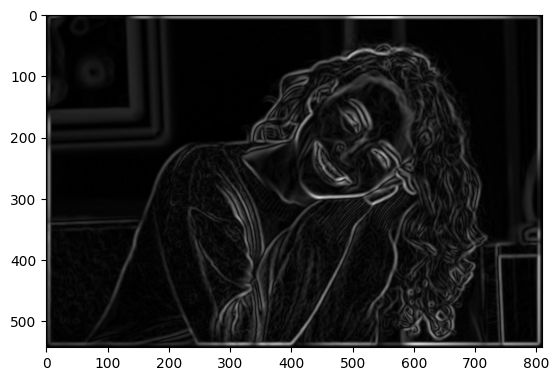

In [14]:
plt.imshow(magnitude, cmap='gray')

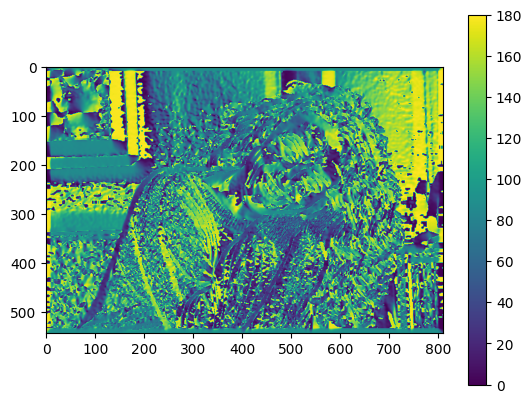

In [15]:
plt.imshow(direction_dg, cmap='viridis')
plt.colorbar()

NON MAXIMA ELIMINATION

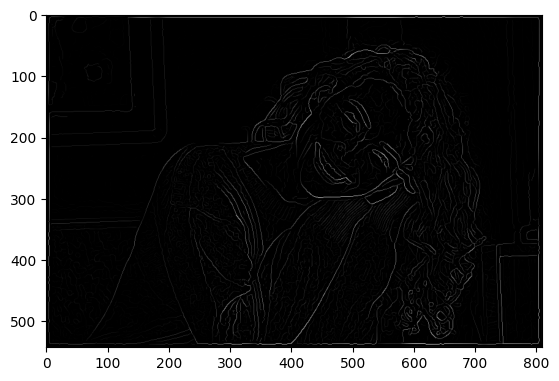

In [16]:
nonMaxima = nonMaximaElimination(magnitude, direction_dg)
plt.imshow(nonMaxima, cmap='gray')

THRESHOLDED IMAGE

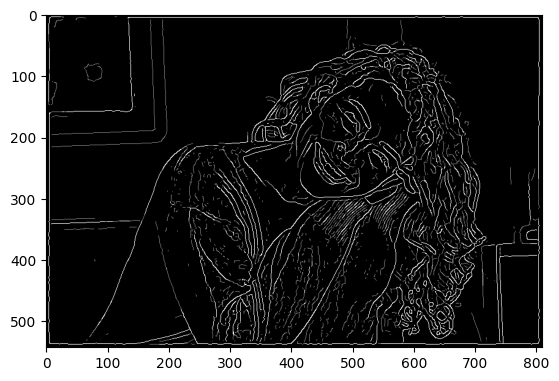

In [17]:
thresholded = threshold_v(nonMaxima, 20, 40)
plt.imshow(thresholded, cmap='gray')

HYSTERESIS IMAGE (FINAL)

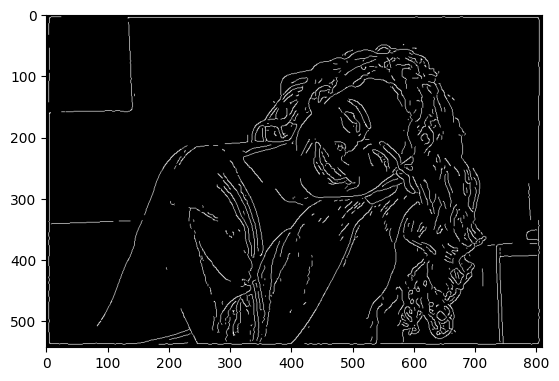

In [18]:
hysteresis_img = hysteresis(thresholded)
plt.imshow(hysteresis_img, cmap='gray')

AND THIS IS THE RESULT! :)